# Bare bones sweep over regularisation parameter for several algorithms 

In [1]:
from cil.recon import FDK
from cil.utilities.display import show2D
import matplotlib.pyplot as plt
import numpy as np
import os
import util

# Choose and load data set

In [2]:
data_set_identifier = 'ta' #'solid_disc' 'ta' 'tb' 'tc' 'td'
datafull = util.load_htc2022data('../HTC2022/data/htc2022_'+data_set_identifier+'_full.mat')

In [3]:
ref = util.loadImg('../HTC2022/data/segmented_references/htc2022_'+data_set_identifier+'_full_recon_fbp_seg.png')

# All parameters here

In [4]:
# Reduce data
ang_start = 0
ang_range = 60

# Image size
im_size = 512

# Upper bound mask
ub_val = 0.040859 # acrylic_attenuation in unit 1/mm
ub_mask_type = 2   # 1 basic 0.97 circle. 2 fitted
def ub_mask_str(ub_mask_type):
    return '97% radius' if ub_mask_type == 1 else 'fitted'

basic_mask_radius = 0.97

# Lower bound mask
lb_mask_type = 0   # 0:  lower bound 0 everywhere, 1: outer annulus equal to upper bound acrylic
lb_inner_radius = 200
lb_val = 0

# Reconstruction
num_iters = 2000

# Segment
segment_type = 2  # 1 basic thresholding, 2 crazy



# Reduce data

In [5]:
data = util.generate_reduced_data(datafull, ang_start, ang_range)
# data = util.load_htc2022data(os.path.abspath("C:/Users/ofn77899/Data/HTC2022/test_input/A.mat"), dataset_name="CtDataLimited")
ang_range = np.abs(data.geometry.angles[-1]-data.geometry.angles[0])


# Image geometry

In [6]:
ig = data.geometry.get_ImageGeometry()
ig.voxel_num_x = im_size
ig.voxel_num_y = im_size

# Preprocess

In [7]:
data_renorm = util.correct_normalisation(data)
data_pad = util.pad_zeros(data_renorm)
data_BHC = util.apply_BHC(data_pad)

# Upper bound mask 0.97 circle or fitted 

In [8]:
def create_circular_mask(ub_mask_type, ub_val, basic_mask_radius=0.97, data=None, ig=None):
    if ub_mask_type == 1:
        ub = ig.allocate(ub_val)
        ub = util.apply_circular_mask(ub, basic_mask_radius)
    elif ub_mask_type == 2:
        # sample mask with upper bound to acrylic attenuation
        ub = ig.allocate(0)
        circle_parameters = util.find_circle_parameters(data, ig)
        util.fill_circular_mask(circle_parameters, ub.array, \
            ub_val, *ub.shape)
    return ub

# Lower bound mask

In [9]:
# lower bound
lb = ig.allocate(0.0)

In [10]:
# def recon_FDK(data, preprocess_data=False):
#     if preprocess_data:
#         data_renorm = util.correct_normalisation(data)
#         data_pad = util.pad_zeros(data_renorm)
#         data_BHC = util.apply_BHC(data_pad)
#     else:
#         data_BHC = data
#     recon = FDK(data_BHC, ig).run()
#     return recon
# recons = [recon_FDK(datafull, preprocess_data=True)]
# titles = ['Full angular range FDK']




In [11]:
# recons.append( recon_FDK(data, preprocess_data=False) )
# titles.append( 'Limited Angle FDK' )

In [12]:
# show2D(recons, title=titles, cmap='inferno')

# Utility function to compute score and make plots compactly

In [13]:
def score_plot(recon_list, title_list, segmethod, ref, do_plot=5):
    
    seg_list = []
    for rr in recon_list:
        if segmethod == 1:
            ss = util.apply_global_threshold(rr)
        elif segment_type == 2:
            ss = util.apply_crazy_threshold(rr)
        seg_list.append(util.flipud_unpack(ss))
    
    score_list = []
    for rr in seg_list:
        score_list.append(util.calcScoreArray(rr, ref))
    
    if do_plot:
        show2D(recon_list, title_list, num_cols=do_plot)
        show2D(seg_list, title_list, num_cols=do_plot)
        
        diffseg_list = []
        for rr in seg_list:
            diffseg_list.append(rr.astype('float32')-ref.astype('float32'))
        show2D(diffseg_list, title_list, num_cols=do_plot)
    
    for i, x in enumerate(title_list):
        print(score_list[i],'\t',x )
    
    return score_list, seg_list

# Building the Optimisation Problem and solving it with PDHG

In [14]:
# def create_lb_ub(data, ig, ub_mask_type, lb_mask_type, ub_val, lb_val, basic_mask_radius, lb_inner_radius):
#     # create default lower bound mask
#     lb = ig.allocate(0.0)
#     # create upper bound mask
#     if ub_mask_type == 1:
#         ub = ig.allocate(ub_val)
#         ub = util.apply_circular_mask(ub, basic_mask_radius)
#     elif ub_mask_type == 2:
#         # sample mask with upper bound to acrylic attenuation
#         ub = ig.allocate(0)
#         circle_parameters = util.find_circle_parameters(data, ig)
#         util.fill_circular_mask(circle_parameters, ub.array, \
#             ub_val, *ub.shape)
#         # create lower bound mask annulus if needed
#         if lb_mask_type == 1:
#             inner_circle_parameters = circle_parameters.copy()
#             inner_circle_parameters[0] = lb_inner_radius
#             util.fill_circular_mask(circle_parameters, lb.array, lb_val, *ub.shape)
#             inner = ig.allocate(0.0)
#             util.fill_circular_mask(inner_circle_parameters, inner.array, 1.0, *ub.shape)
#             lb.array[inner.array.astype(bool)==1.0] = 0.0

#     return lb, ub

In [15]:
from cil.optimisation.functions import L2NormSquared, L1Norm, MixedL21Norm, BlockFunction
from cil.optimisation.operators import GradientOperator, BlockOperator, FiniteDifferenceOperator
from cil.plugins.tigre import ProjectionOperator

def configure_F_K(ig, data, iso_weight, aniso_weight_x, fidelity_weight):
# FinDiff operators in y, x (numpy)
    Grad = GradientOperator(ig)
    A = ProjectionOperator(ig, data.geometry)
    Dx = FiniteDifferenceOperator(ig, direction='horizontal_x')
    K12x = BlockOperator(A, Grad, Dx)

    omega = fidelity_weight
    alpha = iso_weight
    alpha_dx = aniso_weight_x
    f1 = omega*L2NormSquared(b=data)
    f2 = alpha*MixedL21Norm()
    f_dx = alpha_dx*L1Norm()
    F12x = BlockFunction(f1, f2, f_dx)
    
    normK = K12x.norm()
    sigma = 1.0
    tau = 1.0/(sigma*normK**2)
    return F12x, K12x

In [16]:
def segment_and_calculate_score(recon, segmethod, ref):
    
    if segmethod == 1:
        ss = util.apply_global_threshold(recon)
    elif segment_type == 2:
        ss = util.apply_crazy_threshold(recon)
    segmentation = util.flipud_unpack(ss)
    
    score = util.calcScoreArray(segmentation, ref)
        
    return score, segmentation

In [21]:
from cil.optimisation.algorithms import PDHG
from cil.optimisation.functions import IndicatorBox
from cil.framework import AcquisitionData
from algo import IndicatorBoxPixelwise
from skimage.transform import rotate 

recons = []
titles = []

fidelity_weight = 90/ang_range
iso_weight = 0.01
aniso_weight_x = 0.03




segmentations = []
scores = []
# for i,alpha in enumerate(alpha_list):
algopy = True
if not algopy:
    # notice that the fitted mask wants the data non-preprocessed
    if ub_mask_type == 1:
        ub = create_circular_mask(1, ub_val, basic_mask_radius=basic_mask_radius, data=data_BHC, ig=ig)
    elif ub_mask_type == 2:
        ub = create_circular_mask(2, ub_val, data=data, ig=ig)
    else:
        raise ValueError('Unknown mask type. Expected 1 or 2, got {}'.format(ub_mask_type))

    ag_rotated = data_BHC.geometry.copy()
    
    ang_middle = (data_BHC.geometry.angles[0]+data_BHC.geometry.angles[-1])/2
    #ang_start = np.abs(data.geometry.angles[0])
    #ang_range = np.abs(data.geometry.angles[-1]-data.geometry.angles[0])
    #ang_rotate = (ang_start+ang_range/2.0)
    ag_rotated.set_angles(data_BHC.geometry.angles - ang_middle, angle_unit='degree')
    
    data_rotated = AcquisitionData(data_BHC.as_array(), geometry=ag_rotated)

    F, K = configure_F_K(ig, data_rotated, iso_weight, aniso_weight_x, fidelity_weight)

    lb_copy = ig.allocate(0)
    ub_copy = ub.copy()
    lb_copy.array = rotate(lb.as_array(), -ang_middle)
    ub_copy.array = rotate(ub.as_array(), -ang_middle)

    G = IndicatorBoxPixelwise(lower=lb_copy, upper=ub_copy)

    algo = PDHG(operator=K, f=F, g=G, max_iteration=2000, update_objective_interval=100)
    algo.run()
    sol =  algo.solution.copy()
    sol.array = rotate(sol.as_array(), ang_middle)
    
else:
    from algo import pdhg_rotate_isotv_anisotv
    from main import create_lb_ub
    lb_val = 0
    lb, ub = create_lb_ub(data, ig, ub_mask_type, lb_mask_type, 
                                ub_val, lb_val, basic_mask_radius, lb_inner_radius)
    pars = [fidelity_weight, iso_weight, aniso_weight_x]
    sol = pdhg_rotate_isotv_anisotv(data_BHC, ig, lb, ub, *pars, num_iters=2000, update_objective_interval=100, verbose=1)
    # diffseg_list.append(rr.astype('float32')-ref.astype('float32'))

recons.append(sol)
    
tt = 'LS + {} TV + {} anisoTV\nCircular mask: {}'
t =  tt.format(iso_weight, aniso_weight_x, ub_mask_str(ub_mask_type))
titles.append(t)

score, segmentation = segment_and_calculate_score(recons[-1], segment_type, ref)
scores.append(score)
segmentations.append(segmentation)

FDK recon

Input Data:
	angle: 121
	horizontal: 560

Reconstruction Volume:
	horizontal_y: 512
	horizontal_x: 512

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	FFT order: 11
	Filter_inplace: False

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          3.04914e+05
      100       2000         0.034          5.94796e+01
      200       2000         0.034          5.28320e+01
      300       2000         0.034          5.08791e+01
      400       2000         0.034          4.99824e+01
      500       2000         0.034          4.94616e+01
      600       2000         0.034          4.91244e+01
      700       2000         0.034          4.88856e+01
      800       2000         0.034          4.87126e+01
      900       2000         0.034          4.85751e+01
     1000       2000         0.034          4.84644e+01
     1100       2000         0.034          4.83727e+01
     

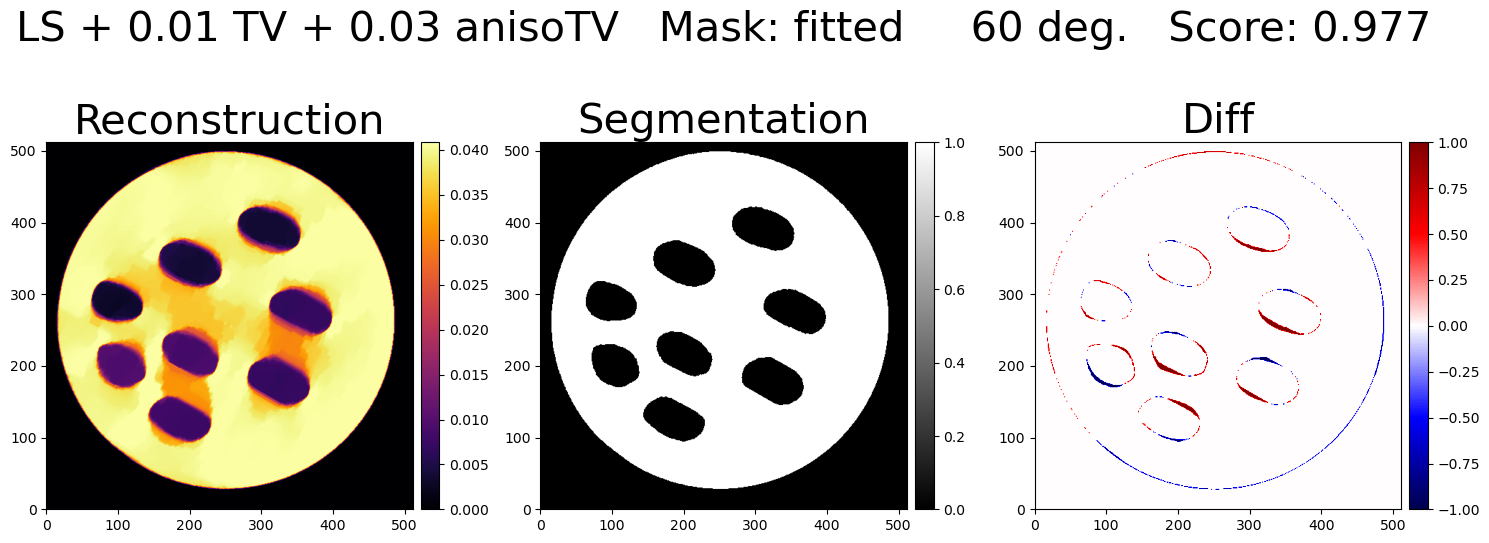

In [20]:

# increase the font size
import matplotlib.pylab as pylab
params = {'axes.titlesize':'30'}
pylab.rcParams.update(params)

tt = 'LS + {} TV + {} anisoTV   Mask: {}   '
t =  tt.format(iso_weight, aniso_weight_x, ub_mask_str(ub_mask_type))
titles[-1] = t

test = show2D([util.flipud_unpack(recons[-1]), 
               segmentations[-1], 
              (segmentations[-1].astype('float32')-ref.astype('float32'))], 
              title=['Reconstruction', 
                     '{}  {:d} deg.   Score: {:.3f}\n\nSegmentation'.format(titles[-1], int(ang_range), scores[-1]), 
                     'Diff'], 
              cmap=['inferno', 'gray', 'seismic'], num_cols=3, 
              )

# test.figure.suptitle(titles[-1], fontsize=16, y=0.7)
# import matplotlib.pyplot as plt
# plt.tight_layout()
# test.figure.show()

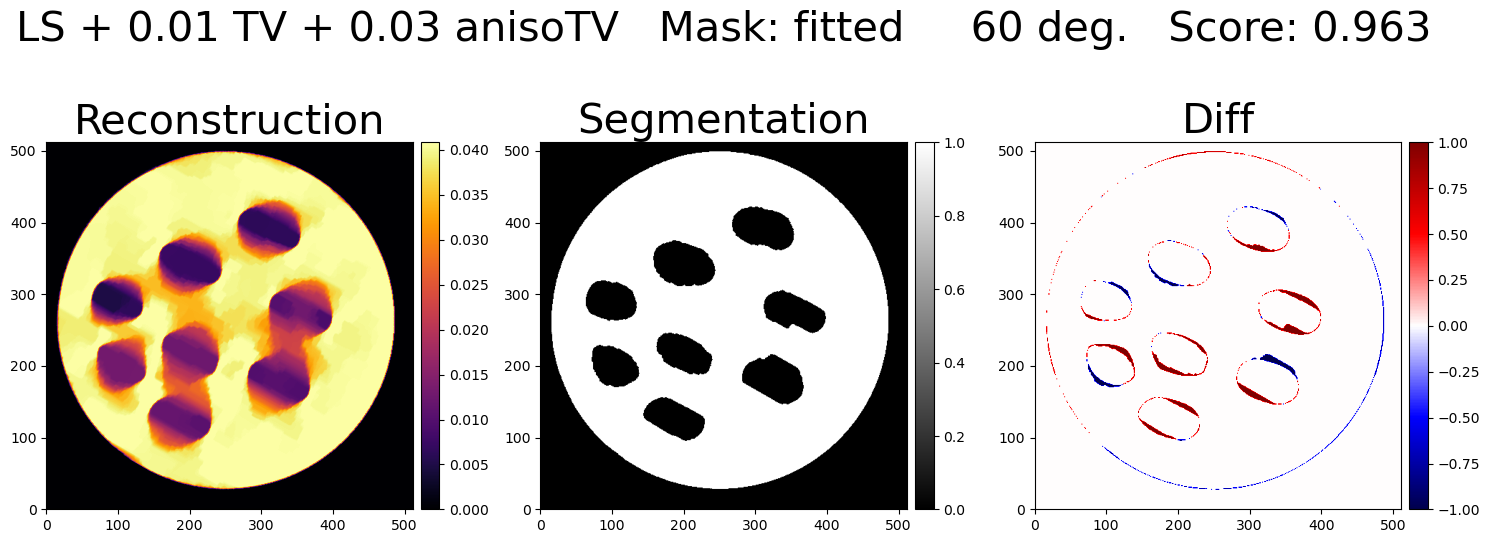

In [22]:

# increase the font size
import matplotlib.pylab as pylab
params = {'axes.titlesize':'30'}
pylab.rcParams.update(params)

tt = 'LS + {} TV + {} anisoTV   Mask: {}   '
t =  tt.format(iso_weight, aniso_weight_x, ub_mask_str(ub_mask_type))
titles[-1] = t

test = show2D([util.flipud_unpack(recons[-1]), 
               segmentations[-1], 
              (segmentations[-1].astype('float32')-ref.astype('float32'))], 
              title=['Reconstruction', 
                     '{}  {:d} deg.   Score: {:.3f}\n\nSegmentation'.format(titles[-1], int(ang_range), scores[-1]), 
                     'Diff'], 
              cmap=['inferno', 'gray', 'seismic'], num_cols=3, 
              )

# test.figure.suptitle(titles[-1], fontsize=16, y=0.7)
# import matplotlib.pyplot as plt
# plt.tight_layout()
# test.figure.show()

In [ ]:
ub_mask_str(1)

# Next recon method PDHG rotate isotv anisotv single-sided

In [ ]:
from algo import pdhg_rotate_isotv_anisotv

In [ ]:
recons_rot = []
titles_rot = []

In [ ]:
alpha_list_rot = np.logspace(-3, -1, 3, endpoint=True)
print(alpha_list_rot)

In [ ]:
for i in alpha_list_rot:
    omega = 90.0/ang_range
    alpha = i
    alpha_dx = i
    pars = [omega, alpha, alpha_dx]

    recons_rot.append(
        pdhg_rotate_isotv_anisotv(data_BHC, ig, lb, ub, *pars, num_iters=num_iters)
    )
    titles_rot.append('PDHG TV rotate aniso samplemask alpha {}'.format(alpha))
    print (titles[-1])

In [ ]:
scores_rot, seg_tor = score_plot(recons_rot, titles_rot, segment_type, ref, 5)

# Next recon method L1-TV-L1